In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [23]:
# Show the first row of the table Station
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x200ff9b8588>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [10]:
# Show the first row of Table Measurement
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x200ff827f98>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(f"The most recent date in the data set is {dt.datetime.strptime(str(recent_date.date), '%Y-%m-%d').date()}.")

The most recent date in the data set is 2017-08-23.


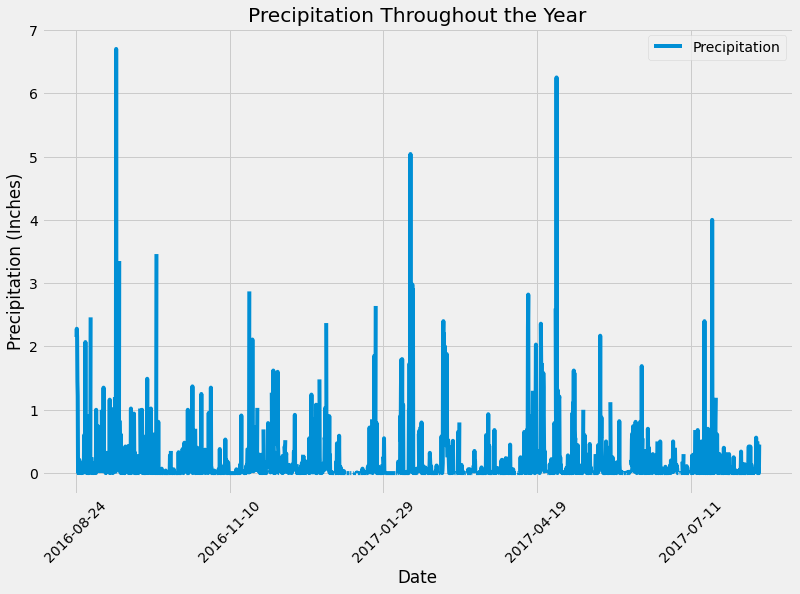

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = dt.datetime.strptime(str(recent_date.date), '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
query_date = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
recent_measurement = session.query(Measurement.date, Measurement.prcp).filter(func.strftime('%Y-%m-%d', Measurement.date) > query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
recent_measurement_df = pd.DataFrame(recent_measurement, columns=['Date', 'Precipitation'])
recent_measurement_df.set_index(recent_measurement_df['Date'], inplace=True)

# Sort the dataframe by date
sorted_measurement_df = recent_measurement_df.sort_index()
sorted_measurement_df.head(10)
# Use Pandas Plotting with Matplotlib to plot the data
sorted_measurement_df.plot(rot=45, figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation Throughout the Year')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_measurement_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_lst = [Measurement.station, func.count(Measurement.station)]

active_station = session.query(*active_station_lst).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first().station

session.query(*active_station_lst).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_lst = [Measurement.station,
           func.min(Measurement.tobs),
           func.max(Measurement.tobs),
           func.avg(Measurement.tobs),
           func.count(Measurement.tobs)]

query = session.query(*temp_lst).group_by(Measurement.station).filter(Measurement.station == active_station).all()

print(f"The most active station id is {query[0][0]}.")
print(f"The lowest temperature is {query[0][1]}.")
print(f"The highest temperature is {query[0][2]}.")
print(f"The average temperature is {query[0][3]}.")

The most active station id is USC00519281.
The lowest temperature is 54.0.
The highest temperature is 85.0.
The average temperature is 71.66378066378067.


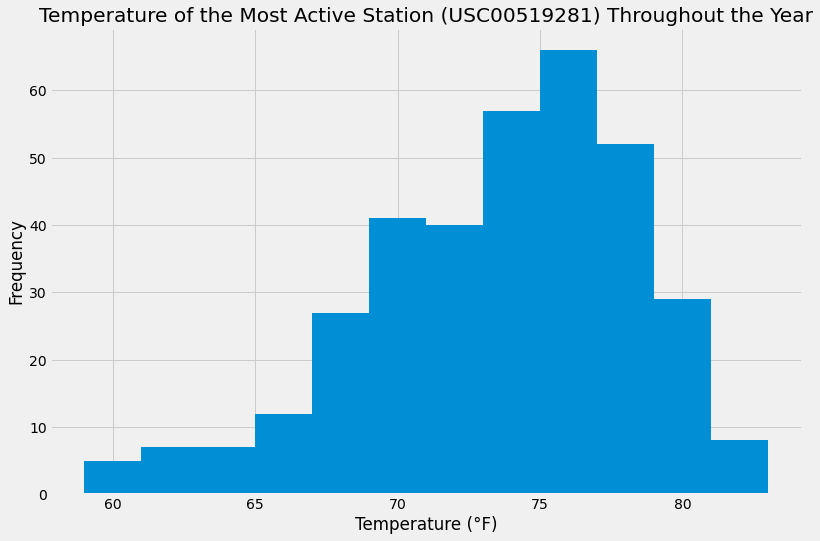

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_temp = session.query(Measurement.station, Measurement.tobs).filter(func.strftime('%Y-%m-%d', Measurement.date) > query_date).filter(Measurement.station == active_station).all()
active_station_temp_df = pd.DataFrame(active_station_temp, columns=['Station', 'Temperature'])
active_station_temp_df.hist(bins=12, figsize=(12, 8))
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature of the Most Active Station ({active_station_temp[0][0]}) Throughout the Year')
plt.show()

# Close session

In [21]:
# Close Session
session.close()